In [1]:
!pip install mpl_finance
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=20e2aae29427ae459928233b3eda334f0d8ffcd20ead18d93af5e446a1ecfcf3
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cuda')

## We'll train on AAPL

In [4]:
apple = yf.Ticker('SPY')
apple_data = apple.history(start="2012-01-01", end="2020-02-29", auto_adjust=True, actions=False)
apple_data

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,108.89,109.42,108.61,108.67,193697900
2012-01-04,108.42,108.94,108.00,108.84,127186500
2012-01-05,108.25,109.29,107.76,109.13,173895000
2012-01-06,109.27,109.29,108.49,108.85,148050000
2012-01-09,109.10,109.25,108.60,109.12,99530200
...,...,...,...,...,...
2020-02-24,323.14,333.56,321.24,322.42,161088400
2020-02-25,323.94,324.61,311.69,312.65,218913200
2020-02-26,314.18,318.11,310.70,311.50,194773800


In [5]:
apple_data.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28'],
              dtype='datetime64[ns]', name='Date', length=2052, freq=None)

In [6]:
apple_data['num_date'] = dates.date2num(apple_data.index)
apple_data

,Open,High,Low,Close,Volume,num_date
Date,,,,,,
2012-01-03,108.89,109.42,108.61,108.67,193697900,734505.0
2012-01-04,108.42,108.94,108.00,108.84,127186500,734506.0
2012-01-05,108.25,109.29,107.76,109.13,173895000,734507.0
2012-01-06,109.27,109.29,108.49,108.85,148050000,734508.0
2012-01-09,109.10,109.25,108.60,109.12,99530200,734511.0
...,...,...,...,...,...,...
2020-02-24,323.14,333.56,321.24,322.42,161088400,737479.0
2020-02-25,323.94,324.61,311.69,312.65,218913200,737480.0
2020-02-26,314.18,318.11,310.70,311.50,194773800,737481.0


In [0]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[['num_date', 'Open', 'High', 'Low', 'Close', 'Volume']]
apple_list = apple.values.tolist()

Plot a candlestick chart for Apples stock

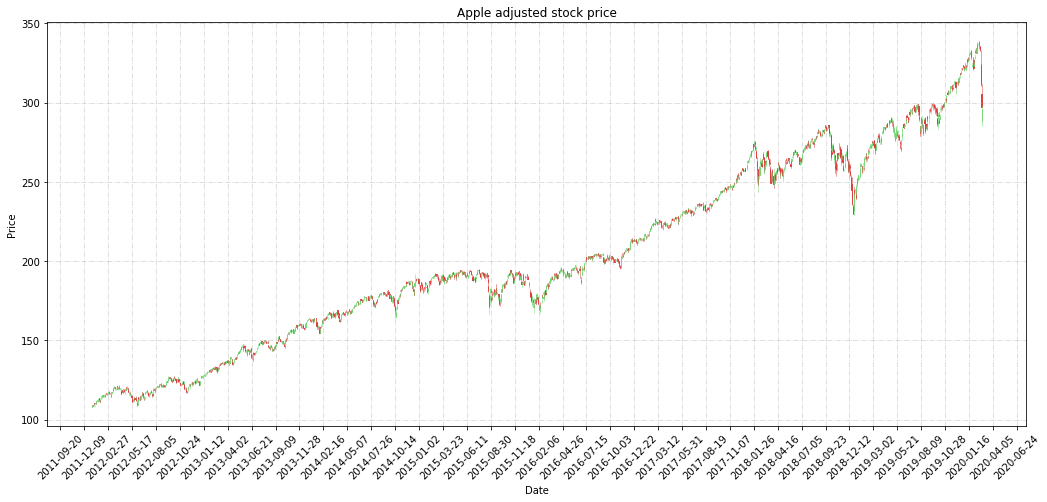

In [0]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [8]:
apple = apple[['Open', 'High', 'Low', 'Close', 'Volume']]
apple

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,108.89,109.42,108.61,108.67,193697900
2012-01-04,108.42,108.94,108.00,108.84,127186500
2012-01-05,108.25,109.29,107.76,109.13,173895000
2012-01-06,109.27,109.29,108.49,108.85,148050000
2012-01-09,109.10,109.25,108.60,109.12,99530200
...,...,...,...,...,...
2020-02-24,323.14,333.56,321.24,322.42,161088400
2020-02-25,323.94,324.61,311.69,312.65,218913200
2020-02-26,314.18,318.11,310.70,311.50,194773800


In [16]:
data = apple.values
data[:3]

array([[1.088900e+02, 1.094200e+02, 1.086100e+02, 1.086700e+02,
        1.936979e+08],
       [1.084200e+02, 1.089400e+02, 1.080000e+02, 1.088400e+02,
        1.271865e+08],
       [1.082500e+02, 1.092900e+02, 1.077600e+02, 1.091300e+02,
        1.738950e+08]])

#### Split the data into training and testing sets

In [0]:
test_size = 365

train_data = data[:-test_size]
test_data = data[-test_size:]

In [18]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)
len(train_data), train_data[:3]

(1687, tensor([[-1.6832, -1.6843, -1.6761, -1.6894,  1.7054],
         [-1.6936, -1.6949, -1.6896, -1.6856,  0.3565],
         [-1.6974, -1.6872, -1.6949, -1.6792,  1.3038]], device='cuda:0'))

In [19]:
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)
len(test_data), test_data[:3]

(365, tensor([[-0.2416, -0.3059, -0.2427, -0.3040, -0.3154],
         [-0.2958, -0.2738, -0.2201, -0.2349, -0.4583],
         [-0.2348, -0.2693, -0.1649, -0.2213, -0.7494]], device='cuda:0'))

In [0]:
# we split the data into 100 day sequences of open, high, low, close data
# and the target value to be the next days closing price.
def create_sequences(input_data, seq_len):
    seq = []
    L = len(input_data)
    for i in range(L-seq_len):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+1][0,3]
        seq.append((train_seq ,train_label))
    return seq

In [21]:
seq_len = 100
train_seq = create_sequences(train_data, seq_len)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 1587 training sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [22]:
test_seq = create_sequences(test_data, seq_len)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [0]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.fc2 = nn.Linear(input_size, 32)
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(32, hidden_size, bidirectional=False)
        self.fc1 = nn.Linear(hidden_size, output_size)
      

        
        self.h0 = torch.zeros(1, 1, hidden_size, device=device)
        
        self.c0 = torch.zeros(1, 1, hidden_size, device=device)

    def forward(self, x):     
        y = self.fc2(x.view(len(x), -1))
        y_relu = F.sigmoid(y)
        out_lstm, (self.h0, self.c0) = self.lstm(y_relu.view(len(x), 1, -1), (self.h0, self.c0))
        out = self.fc1(out_lstm.view(len(x), -1))
        
        return out[-1][0]



In [36]:
model = LSTM(5, 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (fc2): Linear(in_features=5, out_features=32, bias=True)
  (lstm): LSTM(32, 100)
  (fc1): Linear(in_features=100, out_features=1, bias=True)
)


In [37]:
epochs = 30

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, labels) in enumerate(train_seq):
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)
               
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch   1, iteration     0, loss: 0.05191477298736572
Epoch   1, iteration    50, loss: 0.2801829612936126
Epoch   1, iteration   100, loss: 0.002690109558616314
Epoch   1, iteration   150, loss: 0.0017378504241514748
Epoch   1, iteration   200, loss: 0.0011383242681085903
Epoch   1, iteration   250, loss: 0.0011117018118784472
Epoch   1, iteration   300, loss: 0.0026809697184762625
Epoch   1, iteration   350, loss: 0.003977967844416525
Epoch   1, iteration   400, loss: 0.003047890202888084
Epoch   1, iteration   450, loss: 0.005778005137194668
Epoch   1, iteration   500, loss: 0.0017355507370988654
Epoch   1, iteration   550, loss: 0.0014955327364931748
Epoch   1, iteration   600, loss: 0.0060173877863537225
Epoch   1, iteration   650, loss: 0.011545713242603596
Epoch   1, iteration   700, loss: 0.005065783014870249
Epoch   1, iteration   750, loss: 0.0016589990368686357
Epoch   1, iteration   800, loss: 0.0019048798561692594
Epoch   1, iteration   850, loss: 0.015323618265756522
Epoc

Text(0, 0.5, 'loss')

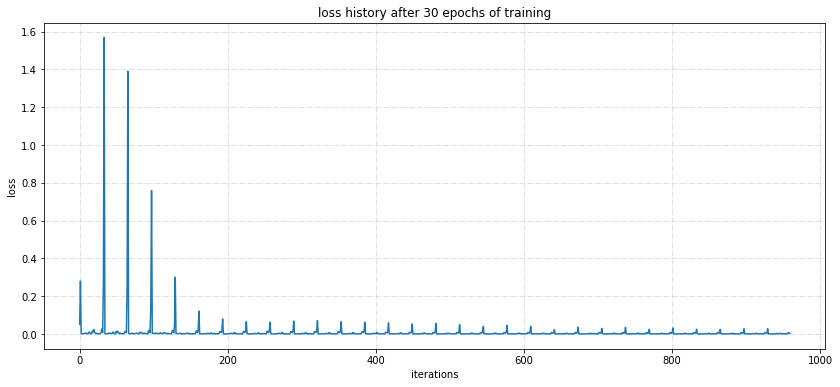

In [38]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

# ax1.xaxis.set_major_locator(mticker.FixedLocator(loc_epochs))
plt.title(f'loss history after 30 epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')
# plt.savefig('/content/drive/My Drive/Deep Learning Final Project/30_SP500-epoch-loss.jpg')

In [39]:
real_labels = []
predicted_labels = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        real_labels.append(label)
        predicted_labels.append(model(seq))
    

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [41]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

0.1692597103867469

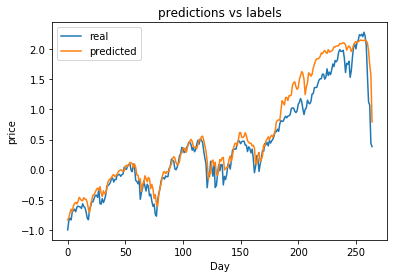

In [45]:
plt.title(f'predictions vs labels')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig('/content/drive/My Drive/Deep Learning Final Project/Linear_first_30_SP500-preds1.jpg')